# Project 2: Automatic Classification of Skin Lesions (Melanoma Detection)


## <center> Taha EZ-ZOURY

## Introduction: 

This project is similar in concept to the previous one, as we will be focusing on image classification. The previous project had an industrial theme, classifying tool wear images, but this project is more oriented towards the health sector, specifically classifying a disease: melanoma detection. Automating such analysis would be extremely beneficial not only for dermatologists, who would be able to make more accurate diagnoses and thus make better decisions regarding the necessity of surgery, but also for general practitioners, who would be able to send patients to specialists more appropriately. Therefore, it could save both economic and time resources for the Social Security system.

In this project, we plan to explore more ways to extract features from images. Since we have the segmentation of the images, we can extract both geometrical/morphological descriptors as well as intensity/texture descriptors.

Setting the work directory:

In [1]:
import os 
# Set the wd (to be modified)
directory = 'C:\\Users\\tahae\\OneDrive\\Bureau\\2A\\TB IPR\\UP3\\Project (skin lesion classification)-20231215'
os.chdir(directory)

## 1.Database:

The database is composed of 200 original images of pigmented skin lesions acquired by
dermoscopy. 100 of them have been histopathologically confirmed as melanomas. Thus two
classes are considered in this project: on the one hand confirmed melanomas and on the
other hand the remaining benign lesions.

In addition to the original images, binary images representing the region of interest of
each lesion are included in the database. The segmentation of the images using superpixels
are also added.

In [2]:
import imageio
import cv2
import matplotlib.pyplot as plt

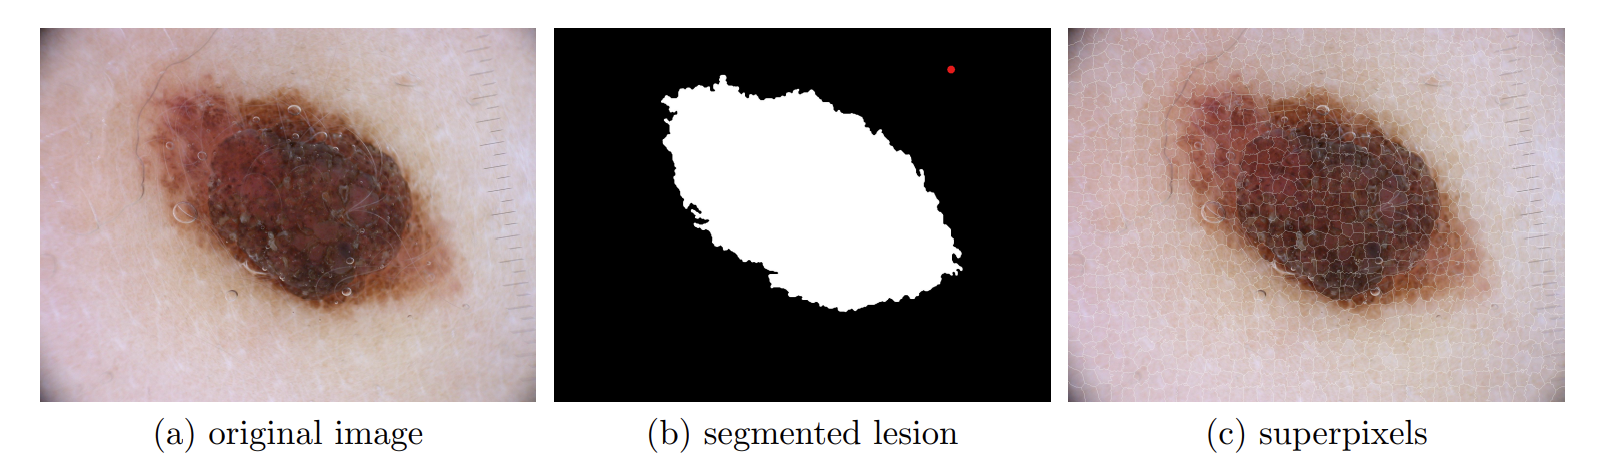

In [78]:
from IPython.display import Image
Image(filename = "1.png", width = 1000, height = 300)

The images aswell as their segmentation and superpixels are in the PROJECT_Data folder. And we have a CSV file labelling the images by associating a class 0 or 1 to each image_id, this class describes if the associated image is cancerous or no.

## 1.a Loading the images:

As mentioned earlier, there are 200 original cases stored in the PROJECT_DATA folder. Each case is represented by three images: the original image, the segmented image, and the superpixel segmented image. To facilitate feature extraction, let's organize these different types of images into three separate categories.

In [3]:
#Reading the files in PROJECT_Data
directory = "./PROJECT_Data"
files = sorted(os.listdir(directory))

#Defining the lists
original_images = []
segmented_images = []
superpixels_images = [] 
ids = []

#Extraction loop
for file in files:
    
    #Image's Id
    id_ = file[:12]    #The ID of the case is in the 12 first characters
    
    #Original Image
    if file == (id_ + ".jpg"):
        original_images.append(cv2.imread(directory + "/" + file))
        ids.append(id_)
    
    #Segmented Image
    elif file == (id_ + "_segmentation.png"):
        segmented_images.append(cv2.imread(directory + "/" + file, cv2.IMREAD_GRAYSCALE))
        
    #Superpixel image
    else:
        superpixels_images.append(cv2.imread(directory + "/" + file, cv2.COLOR_BGR2RGB))
          

Now let's take a look at one of the patterns: 

Text(0.5, 1.0, 'Superpixels Image')

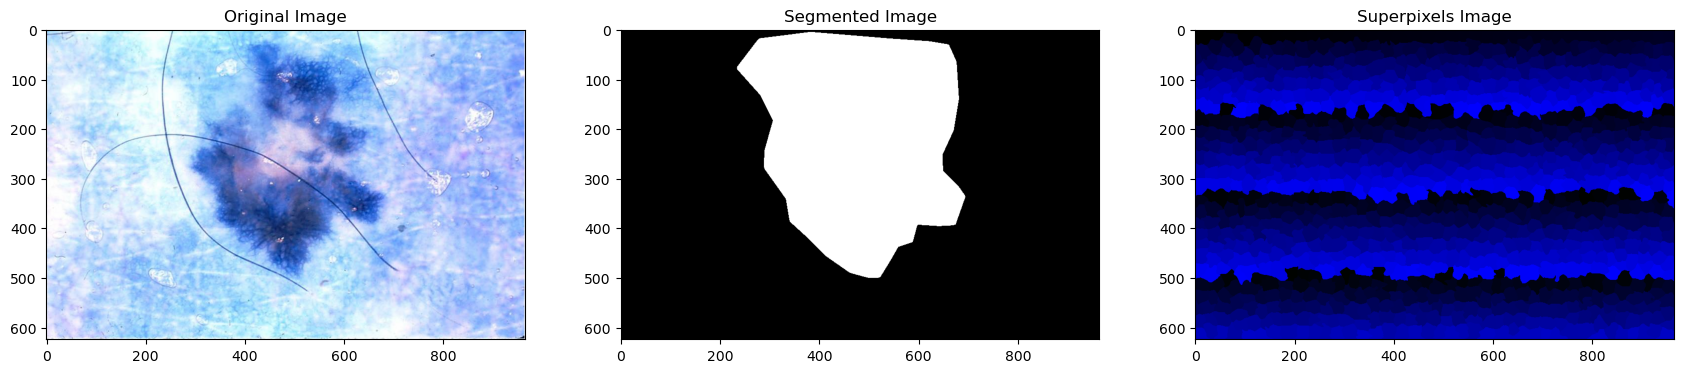

In [4]:
#We choose randomnly
i = 145

#We plot the three corresponding images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (21, 5))

ax1.imshow(original_images[i])
ax1.set_title("Original Image")
ax2.imshow(segmented_images[i], cmap = "gray")
ax2.set_title("Segmented Image")
ax3.imshow(superpixels_images[i])
ax3.set_title("Superpixels Image")


## 1.b Loading the dataset:

We will use the Pandas library to manipulate this dataset.

In [5]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [6]:
labels = pd.read_csv("ISIC-2017_Data_GroundTruth_Classification.csv", delimiter = ",")
labels

,image_id,melanoma,seborrheic_keratosis
0,ISIC_0000000,0.0,0.0
1,ISIC_0000001,0.0,0.0
2,ISIC_0000002,1.0,0.0
3,ISIC_0000003,0.0,0.0
4,ISIC_0000004,1.0,0.0
...,...,...,...
1995,ISIC_0015220,0.0,1.0
1996,ISIC_0015233,0.0,1.0
1997,ISIC_0015260,0.0,1.0
1998,ISIC_0015284,1.0,0.0


We have 2000 elements, representing 2000 lesion images. The binary class "melanoma" describes if the lesion is cancerous, whereas the binary class "seborrheic_keratosis" describes if the lesion is benign and originating keratinocytes cells. (We are going to use just the first 200 elements)

## 2. Features extraction

This aspect of the project is critical, as we are creating variables that will indicate whether a person has skin cancer. It is advisable to consult with medical experts during the feature selection process. Currently, with the segmented images available, we will extract both geometrical/morphological and intensity/texture descriptors. We will then utilize ANOVA F-values to select the most effective features, aiming to narrow it down to the top 30.

## 2.1 Extracting geometrical/morphological descriptors (From segmented images)

In this section, we will utilize the same library as in our first project to extract region properties from the segmented images:

1. **Area**: The total number of pixels within the region.
2. **Bounding Box Area**: The number of pixels within the region's bounding box.
3. **Hu Moments**: Invariant moments (to translation, scale, and rotation) used for shape analysis.
4. **Convex Area**: The number of pixels in the convex hull of the region.
5. **Eccentricity**: The eccentricity of the ellipse that has the same second moments as the region, indicating how elongated it is.
6. **Perimeter**: The length of the border of the region, approximated through the centers of border pixels using 4-connectivity.
7. **Equivalent Diameter**: The diameter of a circle having the same area as the region.
8. **Extent**: The ratio of pixels in the region to the total pixels in the bounding box.
9. **Filled Area**: The total number of pixels in the region, including all internal holes.
10. **Minor Axis Length**: The length of the minor axis of the ellipse with the same normalized second central moments as the region.
11. **Major Axis Length**: The length of the major axis of the ellipse with the same normalized second central moments as the region.
12. **Solidity**: The ratio of pixels in the region to the pixels in the convex hull.
13. **Maximum Feret Diameter**: The longest distance between any two points along the convex hull contour of the region.


In [7]:
from skimage.measure import label, regionprops, regionprops_table
from skimage import util

In [8]:
n=len(segmented_images)

# Extracting features from the first image :
img_ori = segmented_images[0]
rgprops0 = regionprops_table(img_ori,properties=["area","area_bbox","area_convex","axis_major_length","axis_minor_length",
                                               "eccentricity", "equivalent_diameter_area","extent","feret_diameter_max",
                                               "moments_hu", "perimeter", "perimeter_crofton", "solidity"])

In [9]:
pd.DataFrame(rgprops0)

,area,area_bbox,area_convex,axis_major_length,axis_minor_length,eccentricity,equivalent_diameter_area,extent,feret_diameter_max,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6,perimeter,perimeter_crofton,solidity
0,364956.0,498624.0,376696.0,851.808557,556.405972,0.757181,681.671777,0.731926,867.111296,0.177276,0.005075,0.000307,0.000015,7.840447e-10,8.058088e-07,5.681431e-10,2586.885569,2455.202824,0.968834


Let's now do the same to all the images: (the process takes some time to compute all the features)

In [51]:
descriptors=pd.DataFrame(rgprops0)

for i in range(1,n):
    img_ori = segmented_images[i]
    rgprops = regionprops_table(img_ori,properties=["area","area_bbox","area_convex","axis_major_length","axis_minor_length",
                                               "eccentricity", "equivalent_diameter_area","extent","feret_diameter_max",
                                               "moments_hu", "perimeter", "perimeter_crofton", "solidity"])
    rgprops=pd.DataFrame(rgprops)
    
    descriptors=pd.concat([descriptors,pd.DataFrame(rgprops)])

In [52]:
descriptors

,area,area_bbox,area_convex,axis_major_length,axis_minor_length,eccentricity,equivalent_diameter_area,extent,feret_diameter_max,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6,perimeter,perimeter_crofton,solidity
0,364956.0,498624.0,376696.0,851.808557,556.405972,0.757181,681.671777,0.731926,867.111296,0.177276,0.005075,0.000307,1.450325e-05,7.840447e-10,8.058088e-07,5.681431e-10,2586.885569,2455.202824,0.968834
0,53432.0,71250.0,57639.0,276.789839,249.034859,0.436456,260.828939,0.749923,293.615395,0.162158,0.000291,0.000016,1.475303e-07,-2.257944e-13,-2.446112e-09,-3.731302e-14,1068.915872,1016.077310,0.927011
0,237402.0,369564.0,259261.0,618.761026,496.327926,0.597147,549.790519,0.642384,647.113591,0.165649,0.001292,0.000029,3.701074e-07,-4.815521e-13,-1.314864e-08,-1.107658e-12,2421.010460,2297.943360,0.915687
0,260712.0,368439.0,272733.0,612.112946,551.560706,0.433660,576.150005,0.707612,646.799041,0.162752,0.000285,0.000148,1.034695e-07,-4.044427e-13,-1.646862e-09,-2.529089e-14,2187.655121,2076.708626,0.955924
0,269484.0,355618.0,273211.0,682.583151,508.604676,0.666933,585.762482,0.757791,678.434964,0.168052,0.002310,0.000147,3.702619e-06,-6.726593e-11,-1.511785e-07,5.423889e-11,2014.410388,1912.462320,0.986359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,369118.0,602680.0,425892.0,845.601582,581.934162,0.725531,685.547689,0.612461,911.831673,0.178413,0.004062,0.000362,4.460056e-06,-1.967038e-11,-1.837577e-07,1.780133e-10,3594.269478,3410.262658,0.866694
0,193598.0,260463.0,203411.0,549.638309,457.358077,0.554615,496.484269,0.743284,584.939313,0.165058,0.000900,0.000006,7.433403e-07,-1.164165e-12,9.120414e-09,9.771699e-13,1788.285497,1698.082480,0.951758
0,273920.0,480810.0,297527.0,824.587625,432.689420,0.851266,590.563948,0.569705,831.129954,0.197860,0.012639,0.000038,3.434871e-06,3.553377e-11,3.594780e-07,-1.659724e-11,2389.897762,2268.446672,0.920656
0,563610.0,731200.0,625398.0,1053.844650,752.907622,0.699698,847.118964,0.770801,1145.422629,0.186017,0.003635,0.001015,2.746725e-05,-2.506912e-09,1.801371e-07,-3.840475e-09,3338.042856,3167.344588,0.901202


## 2.2 Extracting texture descriptors (From original images)

In this section, we are going to use Local Binary Patterns (LBP) for texture description of the images. We have already implemented LBP in the first UP. For this project, we will employ the `local_binary_pattern` function from the `skimage.feature` package.

Local Binary Patterns (LBP) is a type of visual descriptor used for classification in computer vision. LBP represents a specific case of the Texture Spectrum model and has been proven to be a potent feature for texture classification.

The LBP feature vector is created in a straightforward manner:

- For each pixel in the image, compare its value to each of its 8 neighbors (located on its left-top, left-middle, left-bottom, right-top, etc.). This comparison follows the pixels along a circle, either clockwise or counter-clockwise.

- If the center pixel's value is greater than its neighbor's, assign a "1". Otherwise, assign a "0". This process results in an 8-digit binary number for each pixel, which is often converted to a decimal number for convenience.

- Calculate the histogram representing the frequency of each unique binary number (i.e., each combination of pixels that are smaller or greater than the center pixel).

- Normalize this histogram to complete the LBP feature vector.

As LBP only takes gray-scale images, we'll extract the LBP features from each components of our original images. First let's separate the three RGB components:

In [13]:
red_components,blue_components,green_components=[],[],[]

In [14]:
for i in range(n):
    red_components.append(original_images[i][:,:,0])
    green_components.append(original_images[i][:,:,1])
    blue_components.append(original_images[i][:,:,2])

Now, let's extract LBP features from each components:

In [15]:
from skimage.feature import local_binary_pattern
# settings for LBP : 8 pixels neighbourhood
radius = 1
n_points = 8 * radius

The red component: 

In [16]:
LBP_feats_red=np.full((n,30),pd.NaT)
for i in range(n):
    lbp = local_binary_pattern(red_components[i],n_points,radius,method='uniform')
    #Calculate the histogram
    x = np.unique(lbp.ravel(),return_counts=True)
    # Normalize the histogram
    hist = x[:][1]/sum(x[:][1])
    #Appending the component's features
    for j in range(len(x[0])):
        LBP_feats_red[i][int(x[0][j])]=hist[j]

In [17]:
LBP_features_red=pd.DataFrame(LBP_feats_red)
LBP_features_red=LBP_features_red.dropna(axis=1,how="any")

the blue component:

In [18]:
LBP_feats_blue=np.full((n,30),pd.NaT)
for i in range(n):
    lbp = local_binary_pattern(blue_components[i],n_points,radius,method='uniform')
    #Calculate the histogram
    x = np.unique(lbp.ravel(),return_counts=True)
    # Normalize the histogram
    hist = x[:][1]/sum(x[:][1])
    #Appending the component's features
    for j in range(len(x[0])):
        LBP_feats_blue[i][int(x[0][j])]=hist[j]

In [19]:
LBP_features_blue=pd.DataFrame(LBP_feats_blue)
LBP_features_blue=LBP_features_blue.dropna(axis=1,how="any")

The green component: 

In [20]:
LBP_feats_green=np.full((n,30),pd.NaT)
for i in range(n):
    lbp = local_binary_pattern(green_components[i],n_points,radius,method='uniform')
    #Calculate the histogram
    x = np.unique(lbp.ravel(),return_counts=True)
    # Normalize the histogram
    hist = x[:][1]/sum(x[:][1])
    #Appending the component's features
    for j in range(len(x[0])):
        LBP_feats_green[i][int(x[0][j])]=hist[j]

In [21]:
LBP_features_green=pd.DataFrame(LBP_feats_green)
LBP_features_green=LBP_features_green.dropna(axis=1,how="any")

Now let's add all our texture descriptors in one dataframe 

In [32]:
texture_decriptors=np.hstack([LBP_features_blue,LBP_features_green,LBP_features_red])
texture_decriptors=pd.DataFrame(texture_decriptors)

In [33]:
texture_decriptors

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.012949,0.04112,0.021992,0.111586,0.111568,0.2323,0.082509,0.065086,0.249975,0.070916,...,0.009847,0.031693,0.021329,0.111112,0.12897,0.233938,0.0758,0.059684,0.270749,0.056878
1,0.005672,0.028336,0.009489,0.102296,0.06975,0.255046,0.066397,0.072787,0.340773,0.049454,...,0.005556,0.027952,0.009831,0.104661,0.072267,0.258789,0.067527,0.071716,0.332784,0.048917
2,0.014273,0.049164,0.026511,0.132095,0.147198,0.230557,0.104832,0.073255,0.13992,0.082194,...,0.01009,0.036489,0.025605,0.14286,0.183066,0.249698,0.097354,0.065865,0.125835,0.063138
3,0.009292,0.030396,0.017249,0.095487,0.099258,0.223527,0.06354,0.056782,0.349751,0.054717,...,0.008596,0.028755,0.017448,0.100512,0.109125,0.232035,0.063622,0.054111,0.334359,0.051438
4,0.008963,0.024115,0.017106,0.074498,0.120938,0.143425,0.049022,0.034338,0.476906,0.050689,...,0.007044,0.019979,0.016045,0.078819,0.135441,0.151102,0.046625,0.030337,0.470993,0.043615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.037638,0.069854,0.036519,0.102014,0.105965,0.152072,0.107566,0.091615,0.139051,0.157706,...,0.028088,0.056304,0.037676,0.124163,0.145718,0.183053,0.108362,0.078995,0.1123,0.125341
196,0.032743,0.06901,0.033418,0.100487,0.105847,0.167173,0.118269,0.081315,0.144691,0.147047,...,0.027081,0.059359,0.037742,0.118458,0.142328,0.186117,0.115039,0.07336,0.117065,0.123452
197,0.058883,0.083138,0.050269,0.084509,0.084415,0.096112,0.085419,0.0922,0.192842,0.172214,...,0.040648,0.062,0.058479,0.120062,0.143537,0.137641,0.09331,0.07292,0.151686,0.119718
198,0.038176,0.069629,0.038444,0.103541,0.110365,0.162511,0.113323,0.08516,0.129208,0.149644,...,0.03716,0.067409,0.041372,0.109745,0.109762,0.166719,0.116424,0.084182,0.122538,0.14469


## 2.3 Extracting intensity descriptors (From superpixel Images)

We will now extract intensity descriptors (mean, max and min) from the superpixels.

In [35]:
intensities=np.zeros((n,3))
for i in range(n):
    intensities[i][0]=np.min(superpixels_images[i])
    intensities[i][1]=np.mean(superpixels_images[i])
    intensities[i][2]=np.max(superpixels_images[i])

In [36]:
intensities=pd.DataFrame(intensities)
intensities=intensities.rename(columns={0:"min_intensity",1:"mean_intensity",2:"max_intensity"})
intensities

,min_intensity,mean_intensity,max_intensity
0,0.0,42.214552,255.0
1,0.0,41.359015,255.0
2,0.0,41.878397,255.0
3,0.0,41.963896,255.0
4,0.0,41.999852,255.0
...,...,...,...
195,0.0,42.469183,255.0
196,0.0,42.313157,255.0
197,0.0,42.266003,255.0
198,0.0,42.477231,255.0


We can do the same for the RGB components.

In [37]:
intensities_red=np.zeros((n,3))
for i in range(n):
    intensities_red[i][0]=np.min(red_components[i])
    intensities_red[i][1]=np.mean(red_components[i])
    intensities_red[i][2]=np.max(red_components[i])
intensities_blue=np.zeros((n,3))
for i in range(n):
    intensities_blue[i][0]=np.min(blue_components[i])
    intensities_blue[i][1]=np.mean(blue_components[i])
    intensities_blue[i][2]=np.max(blue_components[i])
intensities_green=np.zeros((n,3))
for i in range(n):
    intensities_green[i][0]=np.min(green_components[i])
    intensities_green[i][1]=np.mean(green_components[i])
    intensities_green[i][2]=np.max(green_components[i])

In [38]:
intensities_RGB=pd.DataFrame(np.hstack([intensities_red,intensities_blue,intensities_green]))
intensities_RGB=intensities_RGB.rename(columns={0:"red_min",1:"red_mean",2:"red_max",3:"blue_min",4:"blue_mean",5:"blue_max",6:"green_min",7:"green_mean",8:"green_max"})
intensities_RGB

,red_min,red_mean,red_max,blue_min,blue_mean,blue_max,green_min,green_mean,green_max
0,20.0,170.699430,255.0,16.0,131.888722,251.0,16.0,148.384247,255.0
1,5.0,165.668786,255.0,13.0,166.313012,255.0,10.0,162.109372,255.0
2,0.0,187.607905,255.0,0.0,136.081207,255.0,0.0,150.808203,255.0
3,15.0,168.369554,255.0,42.0,190.571154,255.0,20.0,176.525692,255.0
4,0.0,79.987706,255.0,0.0,90.450662,255.0,0.0,68.360568,255.0
...,...,...,...,...,...,...,...,...,...
195,15.0,126.311808,249.0,124.0,194.936994,255.0,30.0,129.917057,240.0
196,0.0,162.521955,221.0,36.0,203.283918,238.0,10.0,172.275801,214.0
197,3.0,169.072114,248.0,44.0,227.666377,255.0,21.0,192.852451,254.0
198,27.0,105.398054,157.0,54.0,156.564704,191.0,34.0,124.171902,171.0


Let's merge all our intensity descriptors:

In [39]:
intensity_descriptors=pd.concat([intensities,intensities_RGB],axis=1)
intensity_descriptors

,min_intensity,mean_intensity,max_intensity,red_min,red_mean,red_max,blue_min,blue_mean,blue_max,green_min,green_mean,green_max
0,0.0,42.214552,255.0,20.0,170.699430,255.0,16.0,131.888722,251.0,16.0,148.384247,255.0
1,0.0,41.359015,255.0,5.0,165.668786,255.0,13.0,166.313012,255.0,10.0,162.109372,255.0
2,0.0,41.878397,255.0,0.0,187.607905,255.0,0.0,136.081207,255.0,0.0,150.808203,255.0
3,0.0,41.963896,255.0,15.0,168.369554,255.0,42.0,190.571154,255.0,20.0,176.525692,255.0
4,0.0,41.999852,255.0,0.0,79.987706,255.0,0.0,90.450662,255.0,0.0,68.360568,255.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,42.469183,255.0,15.0,126.311808,249.0,124.0,194.936994,255.0,30.0,129.917057,240.0
196,0.0,42.313157,255.0,0.0,162.521955,221.0,36.0,203.283918,238.0,10.0,172.275801,214.0
197,0.0,42.266003,255.0,3.0,169.072114,248.0,44.0,227.666377,255.0,21.0,192.852451,254.0
198,0.0,42.477231,255.0,27.0,105.398054,157.0,54.0,156.564704,191.0,34.0,124.171902,171.0


## 3 Features selection

We've already picked out many features, but it's good to use fewer input variables. This can make modeling less costly in terms of computing and sometimes even make the model better.

It's important to cut down the number of features. This means looking at how they are related but also by taking into account the classification problem and therefore the categorical target. That's why methods like PCA, which don't consider the target's category, might not be the best choice here.

Instead, we're going to use the ANOVA F-value to choose features. This technique is available in the sklearn library and helps us pick the features that matter most for our target variable.

In [40]:
from sklearn.feature_selection import f_classif,SelectKBest

Let's extract the classes of our images:

In [41]:
Y=np.array(labels.loc[labels["image_id"].isin(ids)]["melanoma"]).astype(int)
Y

array([0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])

### 3.1 Reducing morphological descriptors:

In [53]:
morphological_descriptors=descriptors.copy()
morphological_descriptors

,area,area_bbox,area_convex,axis_major_length,axis_minor_length,eccentricity,equivalent_diameter_area,extent,feret_diameter_max,moments_hu-0,moments_hu-1,moments_hu-2,moments_hu-3,moments_hu-4,moments_hu-5,moments_hu-6,perimeter,perimeter_crofton,solidity
0,364956.0,498624.0,376696.0,851.808557,556.405972,0.757181,681.671777,0.731926,867.111296,0.177276,0.005075,0.000307,1.450325e-05,7.840447e-10,8.058088e-07,5.681431e-10,2586.885569,2455.202824,0.968834
0,53432.0,71250.0,57639.0,276.789839,249.034859,0.436456,260.828939,0.749923,293.615395,0.162158,0.000291,0.000016,1.475303e-07,-2.257944e-13,-2.446112e-09,-3.731302e-14,1068.915872,1016.077310,0.927011
0,237402.0,369564.0,259261.0,618.761026,496.327926,0.597147,549.790519,0.642384,647.113591,0.165649,0.001292,0.000029,3.701074e-07,-4.815521e-13,-1.314864e-08,-1.107658e-12,2421.010460,2297.943360,0.915687
0,260712.0,368439.0,272733.0,612.112946,551.560706,0.433660,576.150005,0.707612,646.799041,0.162752,0.000285,0.000148,1.034695e-07,-4.044427e-13,-1.646862e-09,-2.529089e-14,2187.655121,2076.708626,0.955924
0,269484.0,355618.0,273211.0,682.583151,508.604676,0.666933,585.762482,0.757791,678.434964,0.168052,0.002310,0.000147,3.702619e-06,-6.726593e-11,-1.511785e-07,5.423889e-11,2014.410388,1912.462320,0.986359
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,369118.0,602680.0,425892.0,845.601582,581.934162,0.725531,685.547689,0.612461,911.831673,0.178413,0.004062,0.000362,4.460056e-06,-1.967038e-11,-1.837577e-07,1.780133e-10,3594.269478,3410.262658,0.866694
0,193598.0,260463.0,203411.0,549.638309,457.358077,0.554615,496.484269,0.743284,584.939313,0.165058,0.000900,0.000006,7.433403e-07,-1.164165e-12,9.120414e-09,9.771699e-13,1788.285497,1698.082480,0.951758
0,273920.0,480810.0,297527.0,824.587625,432.689420,0.851266,590.563948,0.569705,831.129954,0.197860,0.012639,0.000038,3.434871e-06,3.553377e-11,3.594780e-07,-1.659724e-11,2389.897762,2268.446672,0.920656
0,563610.0,731200.0,625398.0,1053.844650,752.907622,0.699698,847.118964,0.770801,1145.422629,0.186017,0.003635,0.001015,2.746725e-05,-2.506912e-09,1.801371e-07,-3.840475e-09,3338.042856,3167.344588,0.901202


We have 19 morphological descriptors, let's reduce them to the 10 best features regarding our ANOVA f_value:

In [54]:
k=10
morphological_descriptors=pd.DataFrame(SelectKBest(f_classif, k = k).fit_transform(morphological_descriptors, Y),columns = ["Morphological feature " + str(i) for i in range(1,k+1)])
morphological_descriptors

,Morphological feature 1,Morphological feature 2,Morphological feature 3,Morphological feature 4,Morphological feature 5,Morphological feature 6,Morphological feature 7,Morphological feature 8,Morphological feature 9,Morphological feature 10
0,364956.0,498624.0,376696.0,851.808557,556.405972,681.671777,867.111296,0.000307,1.450325e-05,0.968834
1,53432.0,71250.0,57639.0,276.789839,249.034859,260.828939,293.615395,0.000016,1.475303e-07,0.927011
2,237402.0,369564.0,259261.0,618.761026,496.327926,549.790519,647.113591,0.000029,3.701074e-07,0.915687
3,260712.0,368439.0,272733.0,612.112946,551.560706,576.150005,646.799041,0.000148,1.034695e-07,0.955924
4,269484.0,355618.0,273211.0,682.583151,508.604676,585.762482,678.434964,0.000147,3.702619e-06,0.986359
...,...,...,...,...,...,...,...,...,...,...
195,369118.0,602680.0,425892.0,845.601582,581.934162,685.547689,911.831673,0.000362,4.460056e-06,0.866694
196,193598.0,260463.0,203411.0,549.638309,457.358077,496.484269,584.939313,0.000006,7.433403e-07,0.951758
197,273920.0,480810.0,297527.0,824.587625,432.689420,590.563948,831.129954,0.000038,3.434871e-06,0.920656
198,563610.0,731200.0,625398.0,1053.844650,752.907622,847.118964,1145.422629,0.001015,2.746725e-05,0.901202


### 3.2 Reducing texture descriptors:

In [44]:
texture_decriptors

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.012949,0.04112,0.021992,0.111586,0.111568,0.2323,0.082509,0.065086,0.249975,0.070916,...,0.009847,0.031693,0.021329,0.111112,0.12897,0.233938,0.0758,0.059684,0.270749,0.056878
1,0.005672,0.028336,0.009489,0.102296,0.06975,0.255046,0.066397,0.072787,0.340773,0.049454,...,0.005556,0.027952,0.009831,0.104661,0.072267,0.258789,0.067527,0.071716,0.332784,0.048917
2,0.014273,0.049164,0.026511,0.132095,0.147198,0.230557,0.104832,0.073255,0.13992,0.082194,...,0.01009,0.036489,0.025605,0.14286,0.183066,0.249698,0.097354,0.065865,0.125835,0.063138
3,0.009292,0.030396,0.017249,0.095487,0.099258,0.223527,0.06354,0.056782,0.349751,0.054717,...,0.008596,0.028755,0.017448,0.100512,0.109125,0.232035,0.063622,0.054111,0.334359,0.051438
4,0.008963,0.024115,0.017106,0.074498,0.120938,0.143425,0.049022,0.034338,0.476906,0.050689,...,0.007044,0.019979,0.016045,0.078819,0.135441,0.151102,0.046625,0.030337,0.470993,0.043615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.037638,0.069854,0.036519,0.102014,0.105965,0.152072,0.107566,0.091615,0.139051,0.157706,...,0.028088,0.056304,0.037676,0.124163,0.145718,0.183053,0.108362,0.078995,0.1123,0.125341
196,0.032743,0.06901,0.033418,0.100487,0.105847,0.167173,0.118269,0.081315,0.144691,0.147047,...,0.027081,0.059359,0.037742,0.118458,0.142328,0.186117,0.115039,0.07336,0.117065,0.123452
197,0.058883,0.083138,0.050269,0.084509,0.084415,0.096112,0.085419,0.0922,0.192842,0.172214,...,0.040648,0.062,0.058479,0.120062,0.143537,0.137641,0.09331,0.07292,0.151686,0.119718
198,0.038176,0.069629,0.038444,0.103541,0.110365,0.162511,0.113323,0.08516,0.129208,0.149644,...,0.03716,0.067409,0.041372,0.109745,0.109762,0.166719,0.116424,0.084182,0.122538,0.14469


We have 30 texture features. Let's reduce them to the 15 best features:

In [46]:
texture_desciptors=texture_decriptors.copy()
k=15
texture_descriptors=pd.DataFrame(SelectKBest(f_classif, k = k).fit_transform(texture_desciptors, Y),columns = ["Texture feature " + str(i) for i in range(1,k+1)])
texture_descriptors

,Texture feature 1,Texture feature 2,Texture feature 3,Texture feature 4,Texture feature 5,Texture feature 6,Texture feature 7,Texture feature 8,Texture feature 9,Texture feature 10,Texture feature 11,Texture feature 12,Texture feature 13,Texture feature 14,Texture feature 15
0,0.04112,0.111568,0.2323,0.249975,0.070916,0.02022,0.122627,0.234297,0.247752,0.009847,0.031693,0.12897,0.233938,0.270749,0.056878
1,0.028336,0.06975,0.255046,0.340773,0.049454,0.008926,0.071431,0.256527,0.338517,0.005556,0.027952,0.072267,0.258789,0.332784,0.048917
2,0.049164,0.147198,0.230557,0.13992,0.082194,0.022749,0.174721,0.251075,0.126241,0.01009,0.036489,0.183066,0.249698,0.125835,0.063138
3,0.030396,0.099258,0.223527,0.349751,0.054717,0.016211,0.107045,0.229597,0.342556,0.008596,0.028755,0.109125,0.232035,0.334359,0.051438
4,0.024115,0.120938,0.143425,0.476906,0.050689,0.015219,0.133092,0.152593,0.472067,0.007044,0.019979,0.135441,0.151102,0.470993,0.043615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.069854,0.105965,0.152072,0.139051,0.157706,0.035359,0.14922,0.189239,0.113024,0.028088,0.056304,0.145718,0.183053,0.1123,0.125341
196,0.06901,0.105847,0.167173,0.144691,0.147047,0.031916,0.125356,0.186346,0.134286,0.027081,0.059359,0.142328,0.186117,0.117065,0.123452
197,0.083138,0.084415,0.096112,0.192842,0.172214,0.054208,0.11122,0.116042,0.174393,0.040648,0.062,0.143537,0.137641,0.151686,0.119718
198,0.069629,0.110365,0.162511,0.129208,0.149644,0.038158,0.116725,0.173916,0.124086,0.03716,0.067409,0.109762,0.166719,0.122538,0.14469


### 3.3 Reducing intensity descriptors:

In [47]:
intensity_descriptors_r=intensity_descriptors.copy()
intensity_descriptors_r

,min_intensity,mean_intensity,max_intensity,red_min,red_mean,red_max,blue_min,blue_mean,blue_max,green_min,green_mean,green_max
0,0.0,42.214552,255.0,20.0,170.699430,255.0,16.0,131.888722,251.0,16.0,148.384247,255.0
1,0.0,41.359015,255.0,5.0,165.668786,255.0,13.0,166.313012,255.0,10.0,162.109372,255.0
2,0.0,41.878397,255.0,0.0,187.607905,255.0,0.0,136.081207,255.0,0.0,150.808203,255.0
3,0.0,41.963896,255.0,15.0,168.369554,255.0,42.0,190.571154,255.0,20.0,176.525692,255.0
4,0.0,41.999852,255.0,0.0,79.987706,255.0,0.0,90.450662,255.0,0.0,68.360568,255.0
...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,42.469183,255.0,15.0,126.311808,249.0,124.0,194.936994,255.0,30.0,129.917057,240.0
196,0.0,42.313157,255.0,0.0,162.521955,221.0,36.0,203.283918,238.0,10.0,172.275801,214.0
197,0.0,42.266003,255.0,3.0,169.072114,248.0,44.0,227.666377,255.0,21.0,192.852451,254.0
198,0.0,42.477231,255.0,27.0,105.398054,157.0,54.0,156.564704,191.0,34.0,124.171902,171.0


We have 12 intensity descriptors, let's reduce them to the 5 best features

In [48]:
k=5
intensity_descriptors_r=pd.DataFrame(SelectKBest(f_classif, k = k).fit_transform(intensity_descriptors_r, Y),columns = ["Intensity feature " + str(i) for i in range(1,k+1)])
intensity_descriptors_r

,Intensity feature 1,Intensity feature 2,Intensity feature 3,Intensity feature 4,Intensity feature 5
0,42.214552,170.699430,255.0,251.0,148.384247
1,41.359015,165.668786,255.0,255.0,162.109372
2,41.878397,187.607905,255.0,255.0,150.808203
3,41.963896,168.369554,255.0,255.0,176.525692
4,41.999852,79.987706,255.0,255.0,68.360568
...,...,...,...,...,...
195,42.469183,126.311808,249.0,255.0,129.917057
196,42.313157,162.521955,221.0,238.0,172.275801
197,42.266003,169.072114,248.0,255.0,192.852451
198,42.477231,105.398054,157.0,191.0,124.171902


### 3.4 Merging the descriptors:

Finaly, we merge all the various descriptors :

In [55]:
descriptors_reduced=pd.concat([morphological_descriptors,texture_descriptors,intensity_descriptors_r],axis=1)
descriptors_reduced

,Morphological feature 1,Morphological feature 2,Morphological feature 3,Morphological feature 4,Morphological feature 5,Morphological feature 6,Morphological feature 7,Morphological feature 8,Morphological feature 9,Morphological feature 10,...,Texture feature 11,Texture feature 12,Texture feature 13,Texture feature 14,Texture feature 15,Intensity feature 1,Intensity feature 2,Intensity feature 3,Intensity feature 4,Intensity feature 5
0,364956.0,498624.0,376696.0,851.808557,556.405972,681.671777,867.111296,0.000307,1.450325e-05,0.968834,...,0.031693,0.12897,0.233938,0.270749,0.056878,42.214552,170.699430,255.0,251.0,148.384247
1,53432.0,71250.0,57639.0,276.789839,249.034859,260.828939,293.615395,0.000016,1.475303e-07,0.927011,...,0.027952,0.072267,0.258789,0.332784,0.048917,41.359015,165.668786,255.0,255.0,162.109372
2,237402.0,369564.0,259261.0,618.761026,496.327926,549.790519,647.113591,0.000029,3.701074e-07,0.915687,...,0.036489,0.183066,0.249698,0.125835,0.063138,41.878397,187.607905,255.0,255.0,150.808203
3,260712.0,368439.0,272733.0,612.112946,551.560706,576.150005,646.799041,0.000148,1.034695e-07,0.955924,...,0.028755,0.109125,0.232035,0.334359,0.051438,41.963896,168.369554,255.0,255.0,176.525692
4,269484.0,355618.0,273211.0,682.583151,508.604676,585.762482,678.434964,0.000147,3.702619e-06,0.986359,...,0.019979,0.135441,0.151102,0.470993,0.043615,41.999852,79.987706,255.0,255.0,68.360568
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,369118.0,602680.0,425892.0,845.601582,581.934162,685.547689,911.831673,0.000362,4.460056e-06,0.866694,...,0.056304,0.145718,0.183053,0.1123,0.125341,42.469183,126.311808,249.0,255.0,129.917057
196,193598.0,260463.0,203411.0,549.638309,457.358077,496.484269,584.939313,0.000006,7.433403e-07,0.951758,...,0.059359,0.142328,0.186117,0.117065,0.123452,42.313157,162.521955,221.0,238.0,172.275801
197,273920.0,480810.0,297527.0,824.587625,432.689420,590.563948,831.129954,0.000038,3.434871e-06,0.920656,...,0.062,0.143537,0.137641,0.151686,0.119718,42.266003,169.072114,248.0,255.0,192.852451
198,563610.0,731200.0,625398.0,1053.844650,752.907622,847.118964,1145.422629,0.001015,2.746725e-05,0.901202,...,0.067409,0.109762,0.166719,0.122538,0.14469,42.477231,105.398054,157.0,191.0,124.171902


We end up with 30 features.

# 4 Classification

Before moving any further, it is primordial to normalize our predictors in order to help with the gradient descent and also reduce the influence of high-value predictors.

In [56]:
from sklearn.preprocessing import MinMaxScaler

X=descriptors_reduced
#Normalization of the data
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

We then split our data into Train and Test datasets, with 80% Train and 20% Test.

In [58]:
from sklearn.model_selection import train_test_split

np.random.seed(1234)
test_size=0.2
(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y,
                                                      test_size=test_size,
                                                      random_state=1)

We can now start to build our Classifiers. As done in Project 1, we will use multiple Classifiers:

- Logistic Regression
- Support Vector Machines
- K-Nearest Neighbors
- Decision Trees
- Random Forest Classifier
- Convolutional Neural Networks

In all the methods we will initialize the classifier to be used, train the classifier (Most of the classifiers are in the Sklearn library) and predict the target.

We will evaluate all the classifier models in the next section.

## 4.1 Logistic Regression: 

### Create & train the model: 

In [60]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)

LogisticRegression()

### Prediction

In [61]:
logpred = logreg.predict(X_test)

## 4.2 Support Vector Machine (SVM)

As explained in the first project, Support vector machines (SVMs), also known as support vector networks in machine learning, are types of supervised learning models. These models, along with their associated learning algorithms, are used for tasks like classification and regression analysis. One key feature of the SVM algorithm is its use of various kernel functions, which are essential for its operation. Kernel functions work by mapping data into a higher-dimensional space. Among the different types of kernel functions available, the most common are:

- Linear
- Polynomial
- Radial Basis Function (RBF)
- Sigmoid

For our study, we will be using the default kernel function, RBF (Radial Basis Function).

### Modeling 

In [63]:
from sklearn import svm
svm_ = svm.SVC(kernel='rbf', probability=True)
svm_.fit(X_train, Y_train) 

SVC(probability=True)

### Prediction

In [64]:
svmpred = svm_.predict(X_test)

## 4.3 K-Nearest Neighbors

In statistics, the k-nearest neighbors algorithm (k-NN) is a non-parametric supervised learning method first developed by Evelyn Fix and Joseph Hodges in 1951, and later expanded by Thomas Cover. It is used for classification and regression. In both cases, the input consists of the k closest training examples in a data set.

In k-NN classification, the output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k = 1, then the object is simply assigned to the class of that single nearest neighbor. 

Let's try to find the best value of k using cross validation, we choose the k that corresponds to the best f1_score.

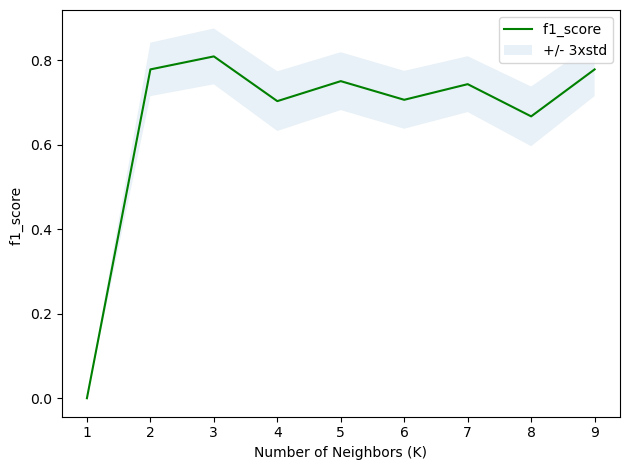

In [67]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

#KNN for different Ks
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(2,Ks):
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train, Y_train)
    yhat = neigh.predict(X_test)
    
    #Computing the accuracy and its standard deviation
    mean_acc[n-1] = metrics.f1_score(Y_test, yhat)
    std_acc[n-1]= np.std(yhat == Y_test)/np.sqrt(yhat.shape[0])

#We plot our results
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('f1_score ', '+/- 3xstd'))
plt.ylabel('f1_score ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [70]:
print( "The best f1_score was with", mean_acc.max(), "with k =", mean_acc.argmax()+1) 

The best f1_score was with 0.8085106382978724 with k = 3


We can now choose our best k and fit our model.

### Modeling

In [71]:
neigh = KNeighborsClassifier(n_neighbors = 3).fit(X_train, Y_train)

### Prediction

In [72]:
knnpred = neigh.predict(X_test)

## 4.4 Decision tree: 

### Modeling

We will first create an instance of the DecisionTreeClassifier called dTree.
Inside of the classifier, we specify criterion="entropy" so we can see the information gain of each node.

In [73]:
from sklearn.tree import DecisionTreeClassifier

dTree = DecisionTreeClassifier(criterion = "entropy", max_depth = 3)
dTree.fit(X_train, Y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

### Prediction 

In [74]:
predTree = dTree.predict(X_test)

## 4.5 Random Forest Classifier:

### Modeling

We will first create an instance of the RandomForestClassifier called rfc.
We create the model with 100 trees.

In [76]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100).fit(X_train, Y_train)

### Prediction: 

In [77]:
rfcpred = rfc.predict(X_test)

## 4.6 Convolutional Neural Networks:

For simplification purposes, we'll only consider sequential and fully-connected neural networks. 

For a case of binary classification, we use the sigmoid function as the last activation function. The output is, just like the logistic regression, a probability of belonging to the positive class.

We will be using the Keras library.

We implemented a shallow neural network, with two single hidden layer with 4 neurons, with respectively a RELU and a tanh activation function. The final activation function is a sigmoid, as it is a binary classification problem.

The function takes multiple hyper-parameters. Amongst them, there is the epoch which is the number of times we go through the entire train set during the gradient descent. The learning rate α which is the step size for the gradient descent, similarly to the logistic regression. And also batchsize which is the number of elements considered to compute the gradient, and therefore the error that will be propaged with the backpropagation.

We decided to not go into more details to explain the intricacies of these hyperparameters as this is not the goal of this TP, however these hyper-parameters should be estimated by bayesian optimization or cross-validation in general, but we will settle with a naïve and arbitrary choice in this TP in order to not dwell on it.


In [79]:
### Neural net

from keras.models import Sequential
from keras.layers import Dense

# build a model
model = Sequential()
model.add(Dense(4, input_shape=(X_train.shape[1],), activation='relu'))
model.add(Dense(4, input_shape=(X_train.shape[1],), activation='tanh')) 
model.add(Dense(1, activation='sigmoid'))
model.summary() 

# compile the model
model.compile(optimizer='Adam', 
              loss='binary_crossentropy',
              metrics=['accuracy'])

# now we just update our model fit call
model.fit(X_train, Y_train,
                    epochs=500,
                    batch_size=20,
                    verbose=0)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 124       
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 149 (596.00 Byte)
Trainable params: 149 (596.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________





### Predicting

In [85]:
#Probabilities
cnnpred_proba = model.predict(X_test)

#Labels
cnnpred_label = []
for i in cnnpred_proba:
    if i[0] >= 0.5:
        cnnpred_label.append(1)
    else:
        cnnpred_label.append(0)
        
cnnpred_label = np.array(cnnpred_label)

2/2 [==============================] - 0s 6ms/step


## 5. Evaluation

Now is finally the time to evaluate all our models. We will use many way to evaluate:

- **Confusion Matrix**: it is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known. The **confusion matrix** itself is relatively simple to understand, but the related terminology can be confusing!

    - True Positive: We predicted positive and it’s true.
    - True Negative: We predicted negative and it’s true.
    - False Positive: (Type 1 Error) We predicted positive and it’s false.
    - False Negative: (Type 2 Error) We predicted negative and it’s false.
    
- **Accuracy**: is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. However, a high accuracy doesn’t mean that our model is best. It is a great measure indeed, but only when we have symmetric datasets where values of false positive and false negatives are almost same. 

<center> $Accuracy = \frac{(TP+TN)}{(TP+TN+FN+FP)}$

- **Fscore** is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F is usually more useful than accuracy, especially if we have an uneven class distribution.

<center> $Fscore = 2*\frac{(\frac{(TP)}{(TP+FN)}*\frac{(TP)}{(TP+FP)})}{(\frac{(TP)}{(TP+FN)}+\frac{(TP)}{(TP+FP)})}$

- **ROC Curve**. The **ROC curve** is a graphical plot that illustrates the diagnostic ability of a binary class ifier system as its discrimination threshold is varied. We take under consideration the **Area Under the Curve**. In general, an **AUC** of *0.5* suggests no discrimination (i.e. ability to diagnose patients with and without the disease or condition based on the test), *0.7* to *0.8* is considered acceptable, *0.8* to *0.9* is considered excellent, and more than *0.9* is considered outstanding

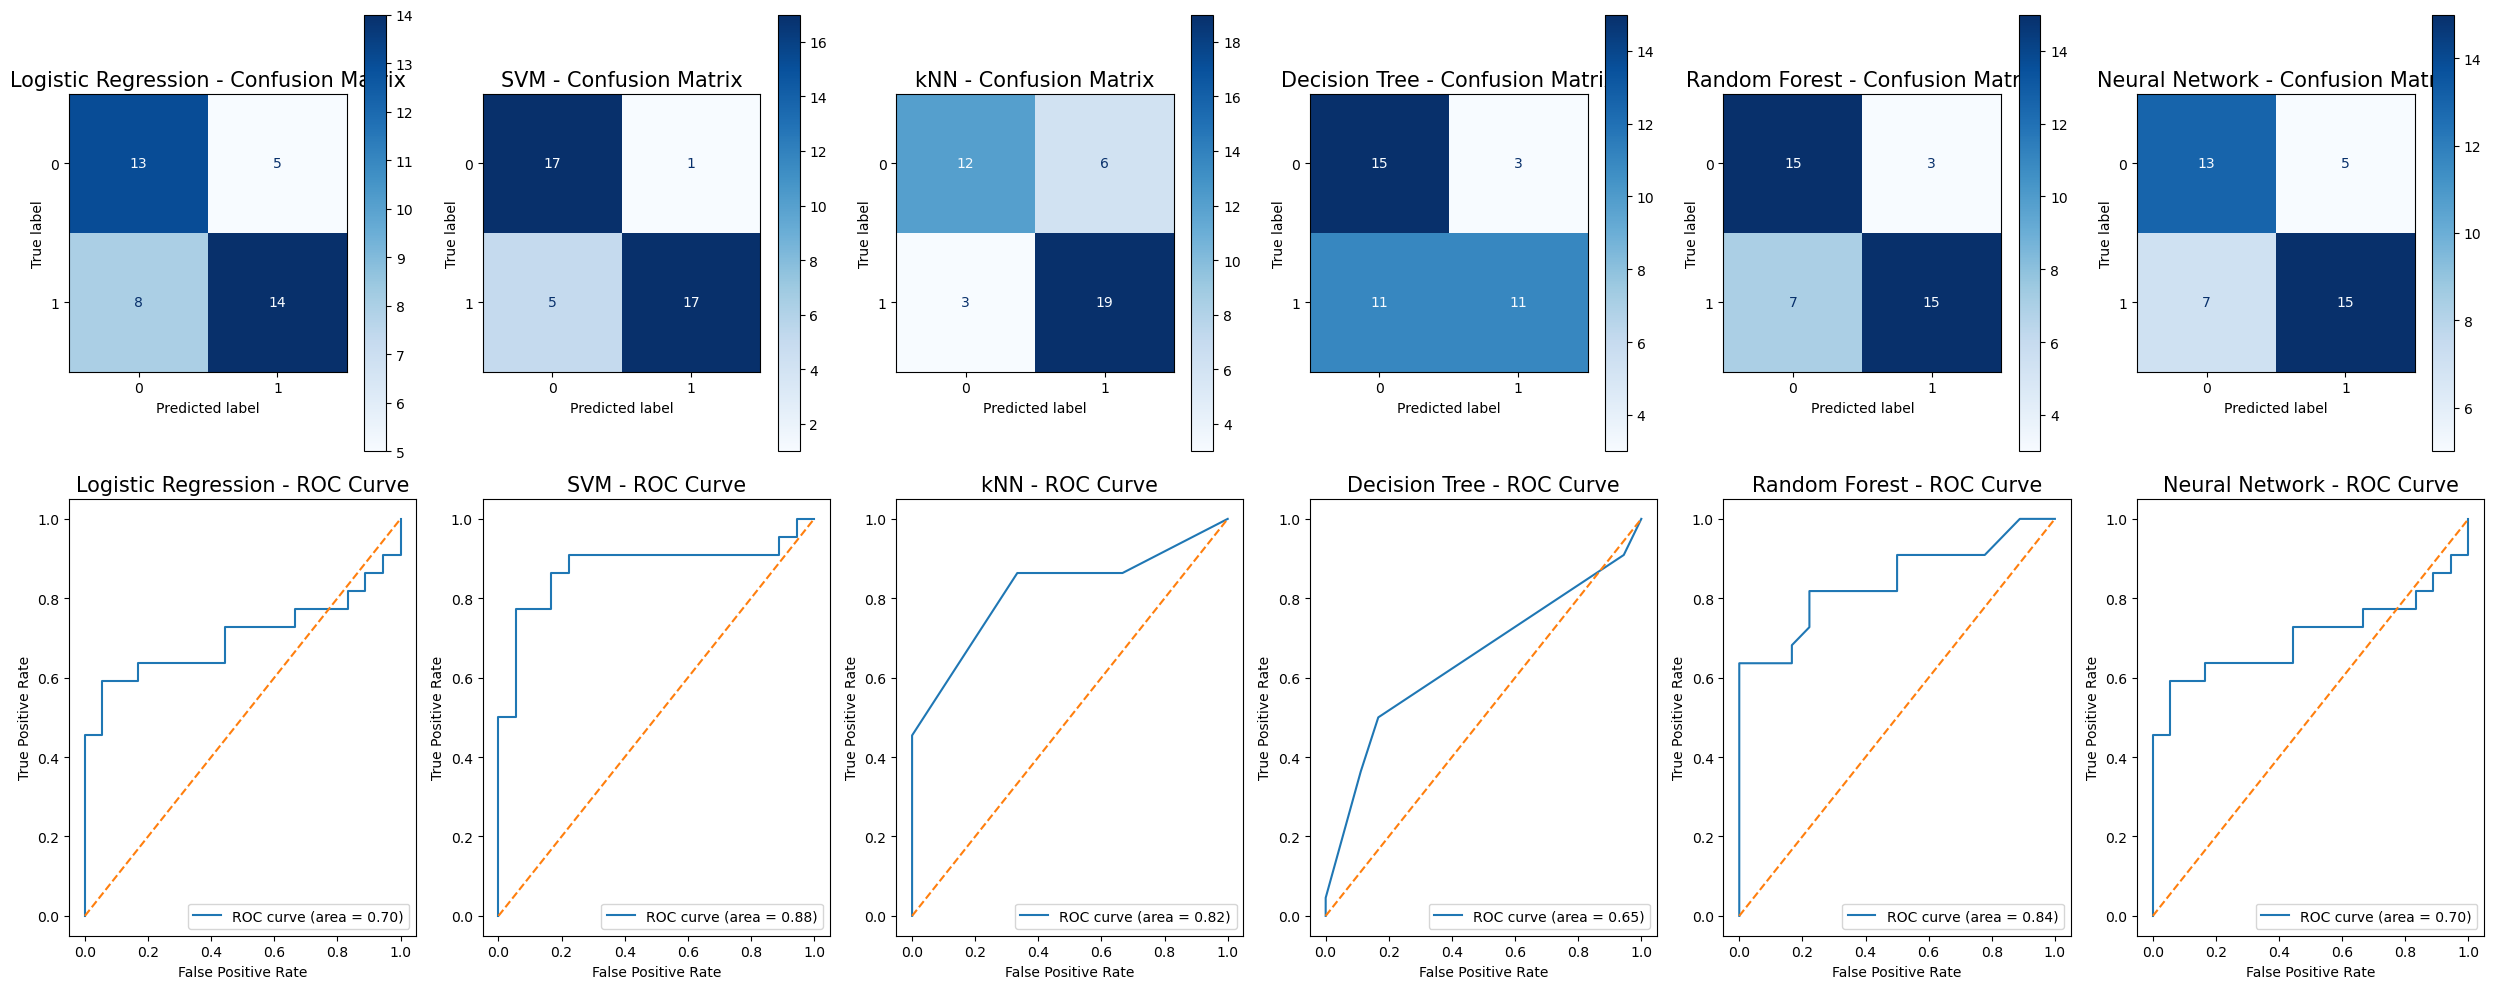

In [109]:
from sklearn.metrics import roc_curve, auc

fig, axs = plt.subplots(2, 6, figsize=(25, 10))

predicted_labels = [logpred, svmpred, knnpred, predTree, rfcpred, cnnpred_label]

# Calculating the predicted score of each model score for ROC curve
predicted_scores=[]
models = [logreg, svm_, neigh, dTree, rfc, model]
for model in models:
    y_score = model.predict_proba(X_test)
    predicted_scores.append(y_score)

names = ["Logistic Regression", "SVM", "kNN", "Decision Tree", "Random Forest", "Neural Network"]

for i, (y_pred, y_score) in enumerate(zip(predicted_labels, predicted_scores)):
    # Confusion Matrix
    cm = confusion_matrix(Y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[0, i], cmap='Blues') 
    axs[0, i].set_title(names[i] + ' - Confusion Matrix', fontsize=15)

    # ROC Curve
    fpr, tpr, _ = roc_curve(Y_test, y_score[:,1]) 
    roc_auc = auc(fpr, tpr)
    axs[1, i].plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    axs[1, i].plot([0, 1], [0, 1], linestyle='--') 
    axs[1, i].set_xlabel('False Positive Rate')
    axs[1, i].set_ylabel('True Positive Rate')
    axs[1, i].set_title(names[i] + ' - ROC Curve', fontsize=15)
    axs[1, i].legend(loc="lower right")

plt.tight_layout()
plt.show()


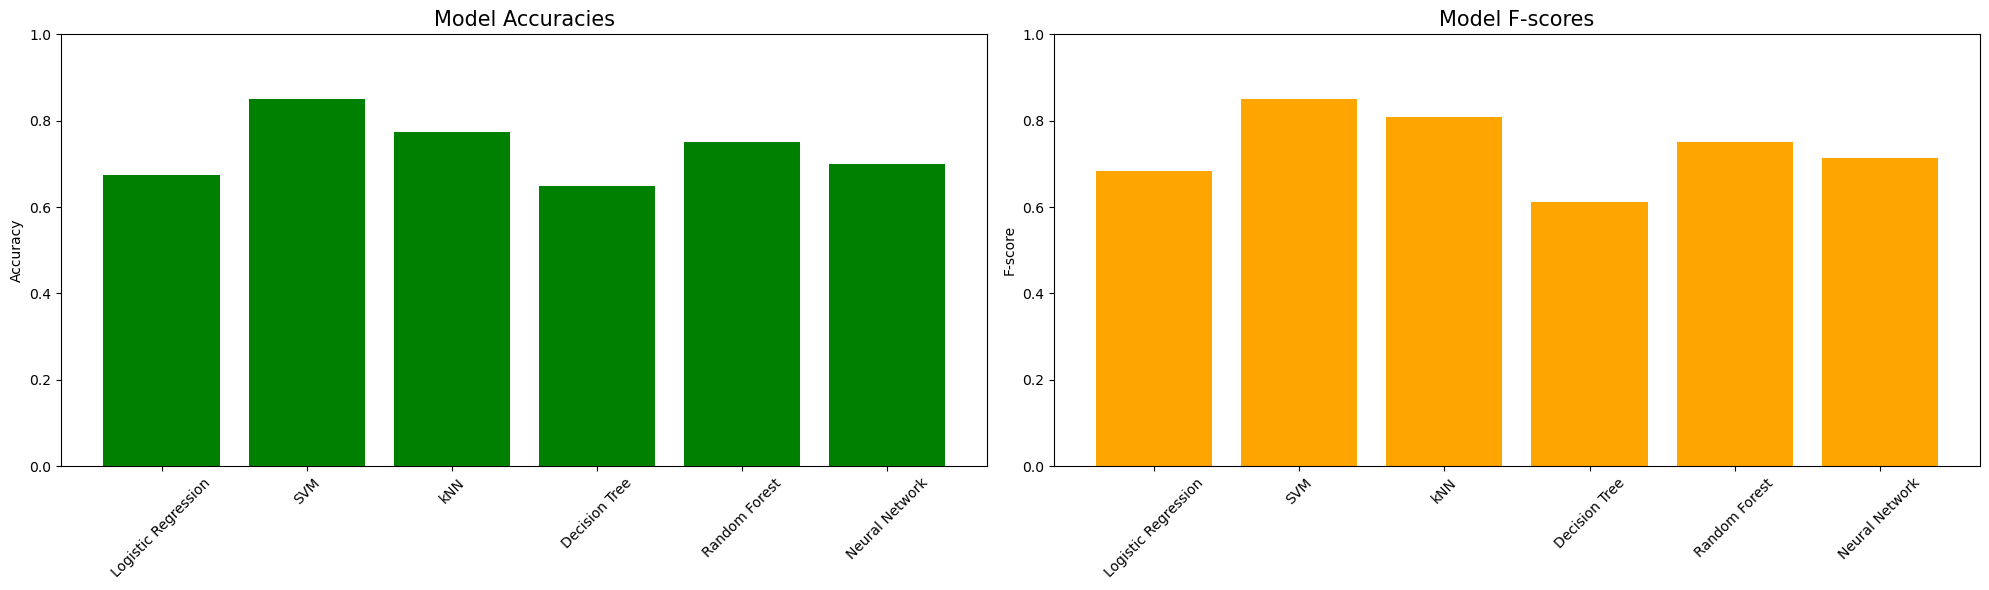

In [110]:
from sklearn.metrics import accuracy_score, f1_score

# Calculate accuracy and F-score for each model
accuracies = [accuracy_score(Y_test, y_pred) for y_pred in predicted_labels]
f_scores = [f1_score(Y_test, y_pred) for y_pred in predicted_labels]

# Creating a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6)) 

# Plotting accuracy
ax1.bar(names, accuracies, color='green')
ax1.set_title('Model Accuracies', fontsize=15)
ax1.set_ylim(0, 1) 
ax1.set_ylabel('Accuracy')
ax1.set_xticklabels(names, rotation=45) 

# Plotting F-score 
ax2.bar(names, f_scores, color='orange')
ax2.set_title('Model F-scores', fontsize=15)
ax2.set_ylim(0, 1)  
ax2.set_ylabel('F-score')
ax2.set_xticklabels(names, rotation=45)

plt.tight_layout()
plt.show()

In [112]:
for i, (accuracy, f_score) in enumerate(zip(accuracies, f_scores)):
    print(names[i],"has an accuracy =", accuracy,"and f_score=", f_score)

Logistic Regression has an accuracy = 0.675 and f_score= 0.6829268292682926
SVM has an accuracy = 0.85 and f_score= 0.85
kNN has an accuracy = 0.775 and f_score= 0.8085106382978724
Decision Tree has an accuracy = 0.65 and f_score= 0.6111111111111112
Random Forest has an accuracy = 0.75 and f_score= 0.7499999999999999
Neural Network has an accuracy = 0.7 and f_score= 0.7142857142857143


Among the models we used, the SVM model proves to be the most accurate, achieving an accuracy of 0.85 and an F-score of 85%. In contrast, the Decision Tree model is the least accurate. As for the Neural Network (NN) model, it has an accuracy of 70%. However, its performance could potentially be improved by optimizing its hyperparameters. 

# Conclusion

In this project, we have explored many aspects. First, creating features for images is crucial for classification. While we developed these features from scratch in the first two UPs, in this UP, we used the 'regionprops' function from the scikit-image library. 

Regarding the classification, I was somewhat familiar with the models, being in data science major, but I had not previously applied them to image classification. 

The models, particularly the Neural Network model, require further optimization for improved classification results.However, it is important to highlight that considering the relatively small sample we had, a more in-depth comparison may be needed to definitely decide which model to use for the classification. For example, for a skin lesion classifier, we may not value False Positives the same way we'd value False Negatives, as it is more important to suspect a cancerous lesion rather than completely ignore it. Therefore, an avenue for improvement would be to focus more on this aspect during the gradient descent by modifying our cost function to describe the relative importance of each case. Furthermore, estimating hyper-parameters for the models by cross-validation is a must in order to try and avoid over-fitting and find the optimized hyper-parameters that can be very important, as we've seen with the variation of performance of the K-NN classifier.

This project highlighted the significance of machine learning in the healthcare sector. I hope to enhance my skills in this area for future projects.